<a href="https://colab.research.google.com/github/lee-seong-wook/ML-DL-study/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 생성자 모델 만둘가
generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim=100, activation='relu'))
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))

# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same", activation=LeakyReLU(0.2)))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기
ginput = Input(shape=(100,))
print(ginput)
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):

# MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 MNIST를 다시 이용, 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 호출
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0~255사이의 값. 이전에 255로 나눠줄 때는 이를 0~1사이의 값으로 바꿨던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나눠서 -1~1사이의 값으로 바뀜

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차 계산
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장하는 부분. 정해진 인터벌(saving_interval)만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 뜻. 이 코드는 본 장의 주된 목표와는 관계가 없어서 소스 코드만 소개한다

          if i % saving_interval == 0:
              # r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("/content/sample_data/%d.png" % i)

gan_train(4001, 32, 200)  # 4000번 반복되고(+1을 하는 것에 주의), 배치 크기는 32,  200번마다 결과가 저장됨

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 conv2d_31 (Conv2D)          (None, 4, 4, 8)          

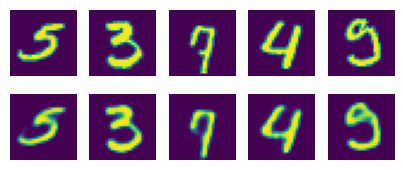

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt

# MNIST데이터 셋을 호출
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델 만들기
autoencoder = Sequential()

# 인코딩 부분
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조 확인
autoencoder.summary()

# 컴파일 및 학습을 하는 부분
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤으로 호출.
ae_imgs = autoencoder.predict(X_test)  # 앞서 만든 오토인코더 모델에 집어넣이기

plt.figure(figsize=(7, 2))  # 출력될 이미지의 크기를 정하기

for i, image_idx in enumerate(random_test):    # 랜덤으로 뽑은 이미지를 차례로 나열
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))  # 테스트할 이미지를 먼저 그대로 보여줌
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음 열에 입력
   ax.axis('off')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Conv2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K

# WGAN-GP에서 사용하는 Gradient Penalty 함수
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    return K.mean(gradient_penalty)

def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(1))
    return model

def build_gan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    img = generator(z)
    validity = discriminator(img)
    return Model(z, validity)

def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, sample_interval=100):
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 판별자 모델 컴파일
    discriminator.compile(loss=wasserstein_loss, optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    # 생성자와 GAN 모델 컴파일
    gan.compile(loss=wasserstein_loss, optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

    for epoch in range(epochs):
        d_loss_total = 0.0
        g_loss_total = 0.0

        for _ in range(X_train.shape[0] // batch_size):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(imgs, -np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.ones((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_y = -np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(noise, valid_y)

            d_loss_total += d_loss
            g_loss_total += g_loss

        # 각 에폭의 평균 손실 출력
        d_loss_avg = d_loss_total / (X_train.shape[0] // batch_size)
        g_loss_avg = g_loss_total / (X_train.shape[0] // batch_size)
        print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss_avg[0]}, G Loss: {g_loss_avg[0]}")

        if epoch % sample_interval == 0:
            generate_and_save_images(generator, epoch, latent_dim)


def generate_and_save_images(generator, epoch, latent_dim, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'generated_images_epoch_{epoch}.png')

# Hyperparameters
latent_dim = 100
img_shape = (28, 28, 1)
epochs = 20000
batch_size = 128

# WGAN-GP에서 사용하는 Wasserstein Loss 함수
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# 모델 생성 및 학습
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)
gan = build_gan(generator, discriminator)

# 훈련
train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim)


4/4 [==============================] - 0s 6ms/step


TypeError: ignored

In [ ]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# 샘플 텍스트 데이터
text_data = """
Hello, how are you doing today?
I hope everything is going well.
This is a simple text generation example.
You can replace this with your own text data.
"""

# 텍스트 데이터 전처리
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_data])
total_words = len(tokenizer.word_index) + 1

# 문장을 시퀀스로 변환
input_sequences = []
for line in text_data.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# 패딩 및 입력/출력 데이터 생성
max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
X, y = input_sequences[:,:-1], input_sequences[:,-1]
y = to_categorical(y, num_classes=total_words)

# LSTM 모델 생성
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)

## 텍스트 생성 함수
def generate_text(seed_text, next_words, model, max_sequence_length):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]

        # 가장 확률이 높은 단어의 인덱스 찾기
        predicted_index = np.argmax(predicted_probs)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# 새로운 텍스트 생성
generated_text = generate_text("Hello", 10, model, max_sequence_length)
print(generated_text)


Epoch 1/100
1/1 - 3s - loss: 3.2229 - accuracy: 0.0000e+00 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 3.2157 - accuracy: 0.0000e+00 - 15ms/epoch - 15ms/step
Epoch 3/100
1/1 - 0s - loss: 3.2087 - accuracy: 0.0417 - 15ms/epoch - 15ms/step
Epoch 4/100
1/1 - 0s - loss: 3.2016 - accuracy: 0.0833 - 15ms/epoch - 15ms/step
Epoch 5/100
1/1 - 0s - loss: 3.1945 - accuracy: 0.0833 - 16ms/epoch - 16ms/step
Epoch 6/100
1/1 - 0s - loss: 3.1871 - accuracy: 0.0833 - 16ms/epoch - 16ms/step
Epoch 7/100
1/1 - 0s - loss: 3.1794 - accuracy: 0.0833 - 16ms/epoch - 16ms/step
Epoch 8/100
1/1 - 0s - loss: 3.1712 - accuracy: 0.0833 - 21ms/epoch - 21ms/step
Epoch 9/100
1/1 - 0s - loss: 3.1624 - accuracy: 0.0833 - 21ms/epoch - 21ms/step
Epoch 10/100
1/1 - 0s - loss: 3.1529 - accuracy: 0.0833 - 14ms/epoch - 14ms/step
Epoch 11/100
1/1 - 0s - loss: 3.1424 - accuracy: 0.0833 - 16ms/epoch - 16ms/step
Epoch 12/100
1/1 - 0s - loss: 3.1309 - accuracy: 0.0833 - 15ms/epoch - 15ms/step
Epoch 13/100
1/1 - 0s - loss: 3.1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.corpus import reuters
import nltk

# nltk 데이터 다운로드
nltk.download('reuters')

# NLTK의 reuters 데이터셋 로드
documents = reuters.fileids()
train_documents = list(filter(lambda doc: doc.startswith("training"), documents))

# 텍스트 데이터 전처리
text_data = " ".join([reuters.raw(doc_id) for doc_id in train_documents[:100]])

# 문장 단위로 텍스트 분할
sentences = text_data.split('\n')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
X, y = input_sequences[:,:-1], input_sequences[:,-1]
y = to_categorical(y, num_classes=total_words)

# LSTM 모델 생성
model = Sequential()
model.add(Embedding(total_words, 250, input_length=max_sequence_length-1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

# 옵티마이저 수정
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)  # 에포크 수 조절

# 예제 라벨 데이터 생성
y_true_example = to_categorical(np.random.randint(0, total_words, size=(32,)), num_classes=total_words)

seed_text = "The"
next_words = 30

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)[0]
    predicted_index = np.argmax(predicted_probs)

    # 인덱스를 단어로 변환
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    seed_text += " " + output_word

print(seed_text)
